# Section 2: Homework Exercises



## Exercise: Auto-tuning Metropolis-Hastings

Modify the Metropolis-Hastings algorithm below by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain, targeting an acceptance rate of around 30%. Call the new function `metropolis_tuned`.

In [ ]:
import numpy as np

age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

rnorm = np.random.normal
runif = np.random.rand

from scipy.stats import gamma, norm
dgamma = gamma.logpdf
dnorm = norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [ ]:
# Write your answer here

def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
     
    n_params = len(initial_values)
             
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
     
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
     
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
     
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
     
    if tune_for is None:
        tune_for = n_iterations/2
     
    for i in range(n_iterations):
     
        if not i%1000: print('Iteration %i' % i)
     
        # Grab current parameter values
        current_params = trace[i]
     
        for j in range(n_params):
     
            # Get current value for parameter j
            p = trace[i].copy()
     
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
             
            # Insert new value 
            p[j] = theta
     
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
     
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
     
            # Sample a uniform random variate
            u = runif()
     
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                 
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
         
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                 
    return trace[tune_for:], accepted

## Exercise: Cancer Rate Estimation

[Tsutakawa et al. (1985)](http://onlinelibrary.wiley.com/doi/10.1002/sim.4780040210/abstract) provides mortality data for stomach cancer among men aged 45-64 in several cities in Missouri. The file `cancer.csv` contains deaths $y_i$ and subjects at risk $n_i$ for 20 cities from this dataset.

In [2]:
import pandas as pd
import numpy as np

cancer = pd.read_csv('../data/cancer.csv')
cancer

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208
5,1,1025
6,0,527
7,2,1668
8,1,583
9,3,582


If we use a simple binomial model, which assumes independent samples from a binomial distribution with probability of mortality $p$, we can use MLE to obtain an estimate of this probability.

$$\hat{p} = \frac{y}{n}$$

In [3]:
p_hat = cancer.y.sum() / cancer.n.sum()
p_hat

0.0009933126276616582

The binomial variance can be caclulated by:

$$\text{Var}(y) = np(1-p)$$

In [4]:
mle_var = (cancer.n * p_hat * (1-p_hat)).sum()
mle_var

70.92947480343602

However, if we compare this to the observed variance in $y$, things don't look good. 

In [5]:
np.var(cancer.y)

134.84750000000003

The data are *overdispersed* relative to what would be expected from a binomial model. As you might expect, it is unrealistic to assume the prevalence of cancer to be the same in all cities. Rather, a more realistic model might allow the probability to vary from place to place, according to any number of unmeasured risk factors. 

Create a hierarchical model that allows the cancer prevalence to vary. 

*Hint: a reasonable distribution for probabilities is the beta distribution. So, you would want to estimate the hyperparameters of the beta distribution to fit the hierarchical model.*

In [7]:
import pymc as pm
import arviz as az

with pm.Model() as cancer_model:

    alpha = pm.Exponential('alpha', 0.1)
    beta = pm.Exponential('beta', 0.1)

    p = pm.Beta('p', alpha, beta, shape=len(cancer))

    y = pm.Binomial('y', n=cancer.n, p=p, observed=cancer.y)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

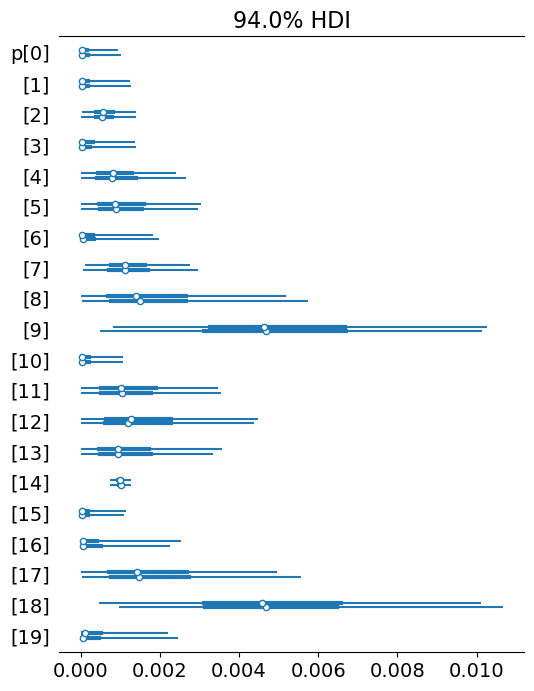

In [8]:
az.plot_forest(trace, var_names='p')